
## I compared the tuned models side by side



In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from sklearn.svm import SVC
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [38]:
X=pd.read_csv('X_train.csv',  index_col=0)
y=pd.read_csv('y_train.csv', header=-1, index_col=0)

X=X.reset_index()
y=y.reset_index()

X.drop(X.columns[[0]],axis=1, inplace=True)
y.drop(y.columns[[0]],axis=1, inplace=True)

In [39]:
from xgboost import XGBClassifier

In [40]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,test_size=0.2,random_state=99)


In [51]:
#ROC-AUC scores for all of our models.
print('\t score\t  std')
results = []
names = []
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('SVC', SVC(kernel='linear',C=1,gamma=0.1)))
models.append(('RF', RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=7, 
                             min_samples_split=18,
                             max_features=4,
                             n_estimators=29)))
models.append(('XGB',  XGBClassifier(bootstrap=True,
                    subsample= 1.0,
                             n_estimators=95,
                             max_depth=4, 
                             learning_rate=0.1,
                             colsample_bytree=0.9,
                             colsample_bylevel=0.1)))

for name, model in models:
    kfold = model_selection.KFold(n_splits = 3, random_state = 99)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

	 score	  std
KNN:	0.700731 (0.061168)
SVC:	0.875028 (0.054153)
RF:	0.895825 (0.034495)
XGB:	0.915109 (0.030080)


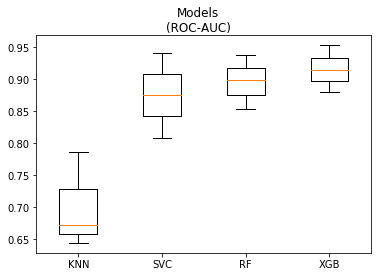

In [52]:
#Let's take a look at these ROC-AUC scores on a box plot
fig = plt.figure()
fig.suptitle('Models\n(ROC-AUC)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

------

* XGB has the best roc/auc score and it's the most stable model.
* KNN is not a good model for this classification

In [53]:
#Let's see the accuracy scores for all of our models. 
models = []
results = []
names = []
print('\t score\t  std')
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('SVC', SVC(kernel='rbf',C=1,gamma=0.1)))
models.append(('RF', RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=7, 
                             min_samples_split=18,
                             max_features=4,
                             n_estimators=29)))
models.append(('XGB',  XGBClassifier(bootstrap=True,
                    subsample= 1.0,
                             n_estimators=95,
                             max_depth=4, 
                             learning_rate=0.1,
                             colsample_bytree=0.9,
                             colsample_bylevel=0.1)))


for name, model in models:
    kfold = model_selection.KFold(n_splits = 3, random_state = 99)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

	 score	  std
KNN:	0.656790 (0.047409)
SVC:	0.532716 (0.060412)
RF:	0.793570 (0.034548)
XGB:	0.826698 (0.043288)


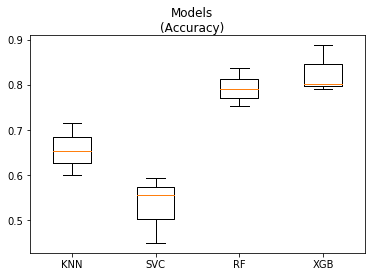

In [54]:
#Let's take a look at the Accuracy scores on a box plot
fig = plt.figure()
fig.suptitle('Models\n(Accuracy)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

* XGB has the highest accuracy score 
* Random Forest is the most stable
* Because the difference in the standard deviation is not that large, I will pick XGB as the best over all model.

#### XGB model evaluation

In [45]:
best_model = XGBClassifier(bootstrap=True,
                    subsample= 1.0,
                             n_estimators=95,
                             max_depth=4, 
                             learning_rate=0.1,
                             colsample_bytree=0.9,
                             colsample_bylevel=0.1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [46]:
from sklearn import metrics
confusion=metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
TP=confusion[1,1]
TN=confusion[0,0]
FP=confusion[0,1]
FN=confusion[1,0]
print (confusion)

[[20  3]
 [ 7 31]]


In [47]:
print('True positive rate\nSpecificity(precision):',TN/(TN+FP))

print('\nTrue negative rate\nSensitivity(recall):',TP/(TP+FN))

True positive rate
Specificity(precision): 0.8695652173913043

True negative rate
Sensitivity(recall): 0.8157894736842105


*  A test that is 87% specific will identify 87% 
    of patients who do not have the disease.

*  A test with 82% sensitivity will identify 82% 
    of patients who have the disease, but will miss 13% of patients who have the disease.

In [48]:
xgb_importance=pd.DataFrame(list(best_model.get_booster().get_score(importance_type='weight').items()))

In [49]:
xgb_fea_imp=pd.DataFrame(list(best_model.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

                 feature  importance
6           cholesterol          91
1            resting_bp          86
3                   age          83
9     num_major_vessels          56
2   thalium_stress_test          48
0               oldpeak          45
5        max_heart_rate          45
10                  sex          43
12           chest_pain          42
11      exercise_angina          40
7           resting_ecg          38
8                 slope          32
4   fasting_blood_sugar          27


<Figure size 2160x1080 with 0 Axes>

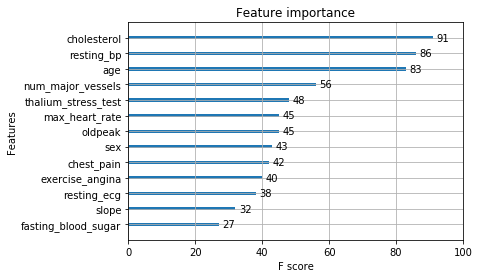

''

In [50]:
plt.figure(figsize=(30,15))
from xgboost import plot_importance
plot_importance(best_model)
plt.show()
;

* The most significant feature to predict heart disease for this model is Cholesterol. 